In [20]:
import torch
#import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
import math

#from Transformer_Model_LayerNorm import ViT
from Transformer_Model_neuron import ViT

In [21]:
import torch
import torchvision
import torchvision.transforms as tranforms
import matplotlib.pyplot as plt

mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
#trainset=torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainset=torchvision.datasets.CIFAR10("~/.torch", download=True)
#trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
mean = [0.5,0.5,0.5] #[0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
std = [0.5,0.5,0.5] #[0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((mean[0],mean[1],mean[2]),
                                                        (std[0],std[1],std[2]))])
trainset=torchvision.datasets.CIFAR100(root='./data',train=True, download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
batch_size= 32 
img_index=[14997, 35084, 22734, 43231, 25373,  2621,  9646, 46119, 26301, 33889,
        34176, 40812, 40034, 43390, 1112, 22934,  8902, 46193, 15375,  1889,
        29713, 47330,  4784, 20510, 26035, 49845,  2768, 10904, 4647,  4894,
         7173, 27221, 39090, 36882, 31181, 14170, 20987, 10058, 14522, 19226,
        47749, 47819, 4162,  8842,  4761, 25366, 39303, 40880, 40981, 10383,
        14196,  2921, 28059, 37463, 40127, 39395, 47778, 35297, 33139, 41811,
         8365, 15851, 16847, 34187,
       48147,   991,  3855, 33109, 18607,  2187, 13727, 18941, 49066,  3842,
        24996, 34891,  5518, 28728, 39464,  2178, 32683, 26223,  1822,  5373,
         6465,  6298, 17017, 49039, 38612, 28229, 47036,  1326, 21858, 23751,
        11325, 47160, 37679, 40829, 12878, 48523,  6648, 32395, 22050, 39155,
         6283, 47866, 37686, 33902, 45390, 40300, 37823, 15962, 23918, 36160,
         7156, 33842, 30559, 39857,  4598, 40083, 4002, 15323, 11925, 39938,
       36953, 37347, 28077, 37410]
img_index[57]=2818
img_index[54]=2047

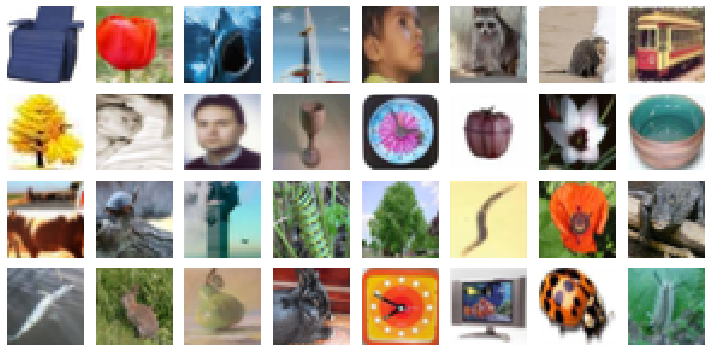

In [23]:

index=img_index #[0:64]
image_list=[]
sum_pix=[]
label=[]
for i in range(len(index)):
    #img =data[i] #validloader.dataset[index[i]]
    img, label2 =trainloader.dataset[index[i]]
    image_list.append(img)
    label.append(label2)
    sum_pix.append(torch.sum(img[:,0:16,16:32]))
image_list=torch.stack(image_list)

mean_inv=torch.tensor(mean).reshape(3,1,1)
std_inv=torch.tensor(std).reshape(3,1,1)
def plot_images(images, rows, cols):
    images = images.clone().detach()
    images=(images*std_inv+mean_inv).clamp(0,1)
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        #ax.imshow(images[i].transpose(1, 2, 0))
        #images[i]=images[i].reshape(3,32,32)
        ax.imshow(images[i].permute(1, 2, 0).cpu());
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(image_list,rows=4,cols=8)

In [24]:
y=label
print(y[0:8])
print(y[8:16])
print(y[16:24])
print(y[32:40])

[25, 92, 73, 76, 11, 66, 64, 81]
[47, 2, 46, 28, 22, 83, 92, 10]
[19, 93, 76, 18, 47, 99, 62, 27]
[70, 30, 8, 86, 27, 4, 42, 41]


In [25]:
RANDOM_SEED = 42
EPOCHS =  1 #40
LEARNING_RATE = 1e-4
NUM_CLASSES = 100
PATCH_SIZE = 16
IMG_SIZE = 32
CHANNELS = 3
global GLOBAL_VAR
GLOBAL_VAR=0
DROPOUT = 0 # 0.001
#HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 1
 
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 
PATCH_DIM = (PATCH_SIZE ** 2) * CHANNELS 
EMBED_DIM = (PATCH_SIZE ** 2) * CHANNELS #* (NUM_PATCHES+1)
NUM_HEADS = 12 #NUM_PATCHES+1
HEAD_DIM= EMBED_DIM//NUM_HEADS
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cpu" if torch.cuda.is_available() else "cpu"

In [26]:
import torch
from torchvision.models import vit_b_16
model=vit_b_16(pretrained=True)
w_glob=model.state_dict()
#print(w_glob.keys())
for key in w_glob.keys():
    print(key)
    print(w_glob[key].shape)

class_token
torch.Size([1, 1, 768])
conv_proj.weight
torch.Size([768, 3, 16, 16])
conv_proj.bias
torch.Size([768])
encoder.pos_embedding
torch.Size([1, 197, 768])
encoder.layers.encoder_layer_0.ln_1.weight
torch.Size([768])
encoder.layers.encoder_layer_0.ln_1.bias
torch.Size([768])
encoder.layers.encoder_layer_0.self_attention.in_proj_weight
torch.Size([2304, 768])
encoder.layers.encoder_layer_0.self_attention.in_proj_bias
torch.Size([2304])
encoder.layers.encoder_layer_0.self_attention.out_proj.weight
torch.Size([768, 768])
encoder.layers.encoder_layer_0.self_attention.out_proj.bias
torch.Size([768])
encoder.layers.encoder_layer_0.ln_2.weight
torch.Size([768])
encoder.layers.encoder_layer_0.ln_2.bias
torch.Size([768])
encoder.layers.encoder_layer_0.mlp.0.weight
torch.Size([3072, 768])
encoder.layers.encoder_layer_0.mlp.0.bias
torch.Size([3072])
encoder.layers.encoder_layer_0.mlp.3.weight
torch.Size([768, 3072])
encoder.layers.encoder_layer_0.mlp.3.bias
torch.Size([768])
encoder.layers

In [27]:
#from Transformer_Model import ViT
r=64 #125
model = ViT(r,EMBED_DIM, PATCH_DIM, PATCH_SIZE, NUM_PATCHES,NUM_HEADS, HEAD_DIM, DROPOUT, CHANNELS, NUM_CLASSES).to(device)

#x=image_list.reshape(batch_size,1,3,32,32)
x=image_list[0].reshape(1,1,3,32,32)
# #print(x)
print(x.shape)
print(model(x).shape)

print(model.parameters)

torch.Size([1, 1, 3, 32, 32])
torch.Size([1, 768])
torch.Size([1, 100])
<bound method Module.parameters of ViT(
  (patch): Create_Patch(
    (fc1): Linear(in_features=768, out_features=768, bias=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
  )
  (mlphead): MLPHead(
    (head): Linear(in_features=768, out_features=100, bias=True)
  )
  (LN): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (encoder1): Encoder(
    (attn): Attention(
      (LN1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (QKV): Linear(in_features=768, out_features=2304, bias=True)
      (msa): Linear(in_features=768, out_features=768, bias=False)
      (adapt1): Linear(in_features=768, out_features=64, bias=True)
      (relu): ReLU()
      (adapt2): Linear(in_features=64, out_features=768, bias=True)
      (res): Residual()
    )
    (mlp): MLP(
      (LN2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (gelu)

In [28]:
GLOBAL_VAR=0
import copy
batch_size=32
y=label[0:batch_size] #.reshape(1)
y=torch.tensor(y)
print(type(y))
#y=torch.tensor(trainloader.dataset[index[16]][1])
print(y)
#y=y.reshape(1)
#print(y)
criterion=nn.CrossEntropyLoss()
target_gradient=copy.deepcopy(model.state_dict())
#optimizer=optim.Adam(model.parameters(), lr=1)
iter=1
#data=data.reshape(batch_size,1,3,32,32)
#x=data[2].reshape(1,1,3,32,32)
data=image_list[0:batch_size].reshape(batch_size,1,3,32,32)
#y=label.reshape(1)
for i in range(iter):
    #optimizer.zero_grad() #used to clear old gradients otherwise they will be accumulated
    #print(model.state_dict())
    model.train()
    output=model(data.to(device))
    loss=criterion(output.to(device),y.to(device))
    model.zero_grad()
    #optimizer.zero_grad()
    loss.backward()
    #optimizer.step() #used to update model parameters
    print(loss)
    #gradient = torch.autograd.grad(loss, model.parameters(), create_graph=True)
target_grad_list=[]
count=0
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name}: {param.grad}")
        target_gradient[name]=param.grad
        target_grad_list.append(param.grad.view(-1))
        if name=='patch.position_embeddings':
            index=count
            gradient_pos=param.grad.view(-1)
        if name=='mlphead.head.weight':
            index=count
            gradient_class=param.grad
        count+=1
            
target_grad_list=torch.cat(target_grad_list)
print(len(target_grad_list))



<class 'torch.Tensor'>
tensor([25, 92, 73, 76, 11, 66, 64, 81, 47,  2, 46, 28, 22, 83, 92, 10, 19, 93,
        76, 18, 47, 99, 62, 27, 73, 65, 57, 65, 22, 87,  7, 18])
torch.Size([32, 768])
tensor(4.6225, grad_fn=<NllLossBackward0>)
patch.cls_token: tensor([[-8.8394e-04, -2.8998e-03, -1.8605e-03, -5.0741e-04,  2.1012e-03,
         -5.2635e-03,  7.5467e-03, -5.7981e-03,  2.8641e-03,  7.7160e-04,
         -1.6049e-03,  4.1175e-03,  1.7662e-03, -1.9684e-03,  2.9954e-03,
          1.4762e-03, -2.9397e-03,  6.6155e-04, -5.5543e-04, -1.1539e-03,
          1.7131e-03, -3.1400e-03, -8.7398e-04,  6.9881e-03,  3.5843e-03,
         -7.4682e-04, -4.4821e-04,  4.0856e-03,  2.1792e-03,  2.7928e-03,
          1.2215e-03,  3.7645e-03,  2.1782e-03, -2.7023e-03, -1.4306e-04,
         -4.1561e-03,  1.5982e-03,  2.1597e-03,  1.9951e-04,  2.5843e-03,
         -4.6046e-03,  3.8104e-03,  2.5246e-04,  1.9584e-04,  1.6413e-03,
          2.2279e-03,  2.2434e-03, -7.4666e-04, -9.6132e-04, -2.8188e-03,
          

encoder3.mlp.fc2.bias: tensor([-2.8175e-03, -4.2344e-03, -2.6754e-03,  2.1585e-03,  2.6019e-03,
        -6.8433e-03,  7.3015e-03, -5.6904e-03,  2.7721e-03,  9.6239e-04,
         1.4391e-03,  4.8654e-03, -1.1899e-03, -1.9699e-03,  2.0277e-03,
        -1.2424e-03, -2.4965e-03,  9.0602e-04,  1.9315e-03, -1.5572e-04,
         1.3184e-04, -2.2672e-03, -5.1415e-03,  3.5420e-03,  2.2778e-03,
         2.9276e-03,  2.5317e-03,  1.0576e-03,  9.6375e-04,  3.9871e-03,
        -1.0724e-03,  5.9229e-03,  1.1533e-03, -4.2632e-04,  9.7947e-05,
        -5.7132e-03,  4.0466e-04, -5.9567e-04,  3.8780e-03,  4.8575e-03,
        -3.4418e-03,  5.4348e-03,  1.2661e-03, -1.4486e-03,  2.8231e-03,
         4.7360e-03,  3.0083e-03,  1.1880e-04, -5.1367e-04, -2.8726e-03,
        -2.8334e-04, -9.1185e-04, -3.3898e-03, -1.6204e-03, -1.1186e-03,
        -3.7531e-03,  7.2690e-04,  4.3965e-03, -8.0194e-03, -3.5448e-03,
        -2.6302e-03,  1.1738e-03, -4.8672e-03, -2.9429e-04, -1.2828e-03,
        -2.3549e-03, -1.1487

encoder6.mlp.adapt2.bias: tensor([-2.9077e-03, -3.5598e-03, -3.4156e-04,  1.7790e-03,  3.6725e-03,
        -7.0477e-03,  6.9140e-03, -4.7212e-03,  1.7289e-03,  1.0022e-03,
        -9.3785e-05,  4.7001e-03, -3.3447e-04, -2.0333e-03,  1.0804e-03,
        -1.1924e-04, -2.4058e-03,  1.5525e-03,  1.2579e-03,  7.7895e-05,
         2.7146e-03, -1.7845e-03, -2.0496e-03,  6.7206e-03,  1.4532e-03,
         1.4601e-03,  4.0207e-03,  4.0111e-03,  2.7419e-03,  5.5171e-03,
        -9.4499e-04,  1.9746e-03,  2.5956e-03,  6.6935e-04, -1.1568e-03,
        -3.4576e-03,  3.6617e-04,  1.2446e-04,  3.8223e-03,  3.1830e-03,
        -2.3384e-03,  2.7257e-03,  1.3739e-03, -2.3104e-03,  2.3772e-03,
         2.4751e-03,  1.6631e-03, -4.4325e-04, -3.6545e-04, -1.4688e-03,
         1.4396e-03,  8.9127e-04, -2.9382e-03,  1.2705e-03, -8.0591e-04,
        -1.2497e-03,  8.4285e-07,  6.0101e-03, -5.6673e-03, -3.2799e-03,
        -1.4930e-03,  8.5774e-04, -2.1971e-03, -2.0733e-05,  5.4080e-05,
         2.8740e-04, -4.3

encoder10.attn.adapt2.bias: tensor([ 1.8567e-04, -1.6328e-03, -1.6127e-04,  9.3928e-04,  2.8386e-03,
        -3.0499e-03,  6.1663e-03, -3.9251e-03,  2.8005e-03,  9.5737e-04,
        -1.3851e-03,  3.2184e-03, -6.8789e-04, -1.6330e-03,  3.0211e-03,
        -1.2292e-04, -1.3350e-03,  1.2943e-03,  2.0720e-03, -1.1916e-03,
         3.0533e-03, -2.3253e-03, -3.6198e-04,  7.9204e-03, -4.5346e-04,
         3.9924e-04,  7.6360e-04,  3.5117e-03,  4.1216e-03,  4.2068e-03,
         2.8876e-04,  1.9181e-03,  3.4451e-03, -9.8528e-04, -1.5649e-03,
        -2.8492e-03,  1.4223e-03,  6.3971e-04,  7.2036e-04,  2.0972e-03,
        -2.3712e-03,  4.1327e-03, -5.6340e-05,  3.3826e-04,  4.8643e-04,
         7.1452e-04,  3.4048e-03, -8.2936e-04,  1.6426e-04, -2.1169e-03,
         2.4328e-03, -5.3482e-04, -3.8351e-03,  5.3224e-03,  1.8597e-03,
        -1.3194e-03,  3.1254e-04,  3.6001e-03, -1.2541e-03, -3.3338e-03,
        -1.8290e-03,  1.3792e-03, -1.6070e-03, -4.5675e-04,  3.8667e-05,
         1.8295e-03, -4

88097380


In [29]:
weight_grad=[]
bias_grad=[]
index1=[]
index2=[]
count=0
for name, param in model.named_parameters():
    if any(f"encoder{i}.{layer}.adapt1.weight" == name for i in range(1, 13) for layer in ["attn", "mlp"]):
        #print(name)
        weight_grad.append(param.grad.view(-1))
        index1.append(count)
    count+=1
count=0
for name, param in model.named_parameters():
    if any(f"encoder{i}.{layer}.adapt1.bias" == name for i in range(1, 13) for layer in ["attn", "mlp"]):
        #print(name)
        bias_grad.append(param.grad.view(-1))
        index2.append(count)
    count+=1
weight_grad=torch.cat(weight_grad)
bias_grad=torch.cat(bias_grad)

In [ ]:
print(index1)

In [ ]:
print(index2)

In [ ]:
print(weight_grad.shape)
print(bias_grad.shape)

In [30]:
target_grad=torch.concat((weight_grad,bias_grad),axis=0)
print(target_grad.shape)

torch.Size([1181184])


In [31]:
import torch.nn.functional as F
cossim=F.cosine_similarity(target_grad, target_grad, dim=0)
print("cossim", cossim)

cossim tensor(1.0001)


In [ ]:
s=torch.sum(gradient_class, axis=1)
# print(s.shape)
# print(s)
values, labels=torch.topk(s,k=batch_size, largest=False)
# print(labels)
# print(labels.sort())

In [32]:
import time
start=time.time()
from Inversion import inversion_attack 
recovered, reconstruction_loss=inversion_attack(IMG_SIZE, model,index1,index2, target_grad.to(device), batch_size,y,2000,mean_inv, std_inv)
end=time.time()

iter: 0
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.1500, grad_fn=<AddBackward0>)
iter: 1
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0987, grad_fn=<AddBackward0>)
iter: 2
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0795, grad_fn=<AddBackward0>)
iter: 3
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0619, grad_fn=<AddBackward0>)
iter: 4
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0562, grad_fn=<AddBackward0>)
iter: 5
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0506, grad_fn=<AddBackward0>)
iter: 6
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0487, grad_fn=<AddBackward0>)
iter: 7
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0476, grad_fn=<AddBackward0>)
iter: 8
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0440, grad_fn=<AddBackward0>)
iter: 9
Current learning rate: 0.1
to

recon loss
tensor(0.0180, grad_fn=<AddBackward0>)
iter: 77
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0177, grad_fn=<AddBackward0>)
iter: 78
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0185, grad_fn=<AddBackward0>)
iter: 79
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0192, grad_fn=<AddBackward0>)
iter: 80
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0193, grad_fn=<AddBackward0>)
iter: 81
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0186, grad_fn=<AddBackward0>)
iter: 82
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0187, grad_fn=<AddBackward0>)
iter: 83
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0186, grad_fn=<AddBackward0>)
iter: 84
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0197, grad_fn=<AddBackward0>)
iter: 85
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0200, gr

recon loss
tensor(0.0191, grad_fn=<AddBackward0>)
iter: 153
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0199, grad_fn=<AddBackward0>)
iter: 154
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0198, grad_fn=<AddBackward0>)
iter: 155
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0194, grad_fn=<AddBackward0>)
iter: 156
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0185, grad_fn=<AddBackward0>)
iter: 157
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0189, grad_fn=<AddBackward0>)
iter: 158
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0184, grad_fn=<AddBackward0>)
iter: 159
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0186, grad_fn=<AddBackward0>)
iter: 160
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0181, grad_fn=<AddBackward0>)
iter: 161
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0

recon loss
tensor(0.0179, grad_fn=<AddBackward0>)
iter: 229
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0169, grad_fn=<AddBackward0>)
iter: 230
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0163, grad_fn=<AddBackward0>)
iter: 231
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0171, grad_fn=<AddBackward0>)
iter: 232
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0167, grad_fn=<AddBackward0>)
iter: 233
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0165, grad_fn=<AddBackward0>)
iter: 234
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0164, grad_fn=<AddBackward0>)
iter: 235
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0176, grad_fn=<AddBackward0>)
iter: 236
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0178, grad_fn=<AddBackward0>)
iter: 237
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0

recon loss
tensor(0.0185, grad_fn=<AddBackward0>)
iter: 305
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0192, grad_fn=<AddBackward0>)
iter: 306
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0184, grad_fn=<AddBackward0>)
iter: 307
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0182, grad_fn=<AddBackward0>)
iter: 308
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0191, grad_fn=<AddBackward0>)
iter: 309
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0181, grad_fn=<AddBackward0>)
iter: 310
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0190, grad_fn=<AddBackward0>)
iter: 311
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0180, grad_fn=<AddBackward0>)
iter: 312
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0188, grad_fn=<AddBackward0>)
iter: 313
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0

recon loss
tensor(0.0180, grad_fn=<AddBackward0>)
iter: 381
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0179, grad_fn=<AddBackward0>)
iter: 382
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0186, grad_fn=<AddBackward0>)
iter: 383
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0186, grad_fn=<AddBackward0>)
iter: 384
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0173, grad_fn=<AddBackward0>)
iter: 385
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0176, grad_fn=<AddBackward0>)
iter: 386
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0170, grad_fn=<AddBackward0>)
iter: 387
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0162, grad_fn=<AddBackward0>)
iter: 388
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0163, grad_fn=<AddBackward0>)
iter: 389
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0

recon loss
tensor(0.0171, grad_fn=<AddBackward0>)
iter: 457
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0172, grad_fn=<AddBackward0>)
iter: 458
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0170, grad_fn=<AddBackward0>)
iter: 459
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0171, grad_fn=<AddBackward0>)
iter: 460
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0170, grad_fn=<AddBackward0>)
iter: 461
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0168, grad_fn=<AddBackward0>)
iter: 462
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0171, grad_fn=<AddBackward0>)
iter: 463
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0176, grad_fn=<AddBackward0>)
iter: 464
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0.0176, grad_fn=<AddBackward0>)
iter: 465
Current learning rate: 0.1
torch.Size([32, 768])
recon loss
tensor(0

recon loss
tensor(0.0135, grad_fn=<AddBackward0>)
iter: 528
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0135, grad_fn=<AddBackward0>)
iter: 529
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0135, grad_fn=<AddBackward0>)
iter: 530
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0135, grad_fn=<AddBackward0>)
iter: 531
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0132, grad_fn=<AddBackward0>)
iter: 532
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0131, grad_fn=<AddBackward0>)
iter: 533
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0130, grad_fn=<AddBackward0>)
iter: 534
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0130, grad_fn=<AddBackward0>)
iter: 535
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0122, grad_fn=<AddBackward0>)
iter: 594
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0120, grad_fn=<AddBackward0>)
iter: 595
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0119, grad_fn=<AddBackward0>)
iter: 596
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 597
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 598
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0117, grad_fn=<AddBackward0>)
iter: 599
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0117, grad_fn=<AddBackward0>)
iter: 600
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0116, grad_fn=<AddBackward0>)
iter: 601
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 660
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 661
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 662
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 663
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 664
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 665
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 666
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0113, grad_fn=<AddBackward0>)
iter: 667
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0112, grad_fn=<AddBackward0>)
iter: 726
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0111, grad_fn=<AddBackward0>)
iter: 727
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0113, grad_fn=<AddBackward0>)
iter: 728
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 729
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0112, grad_fn=<AddBackward0>)
iter: 730
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0111, grad_fn=<AddBackward0>)
iter: 731
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0112, grad_fn=<AddBackward0>)
iter: 732
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0110, grad_fn=<AddBackward0>)
iter: 733
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 792
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 793
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 794
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 795
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 796
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 797
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 798
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 799
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 858
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 859
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 860
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0120, grad_fn=<AddBackward0>)
iter: 861
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 862
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0117, grad_fn=<AddBackward0>)
iter: 863
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0118, grad_fn=<AddBackward0>)
iter: 864
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0116, grad_fn=<AddBackward0>)
iter: 865
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0117, grad_fn=<AddBackward0>)
iter: 924
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0117, grad_fn=<AddBackward0>)
iter: 925
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 926
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0112, grad_fn=<AddBackward0>)
iter: 927
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 928
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 929
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 930
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 931
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0114, grad_fn=<AddBackward0>)
iter: 990
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 991
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0115, grad_fn=<AddBackward0>)
iter: 992
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0113, grad_fn=<AddBackward0>)
iter: 993
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0110, grad_fn=<AddBackward0>)
iter: 994
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 995
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0110, grad_fn=<AddBackward0>)
iter: 996
Current learning rate: 0.010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0112, grad_fn=<AddBackward0>)
iter: 997
Current learning rate: 0.010000000000000002
torch.Size([32

recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1055
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1056
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1057
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1058
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1059
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1060
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1061
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1062
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1120
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1121
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1122
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1123
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1124
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1125
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1126
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1127
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0109, grad_fn=<AddBackward0>)
iter: 1185
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0109, grad_fn=<AddBackward0>)
iter: 1186
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1187
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1188
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1189
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1190
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1191
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1192
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1250
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1251
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1252
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1253
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1254
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1255
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1256
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1257
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1315
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1316
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1317
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1318
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1319
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1320
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1321
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1322
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1380
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1381
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1382
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1383
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1384
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1385
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1386
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1387
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1445
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1446
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1447
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1448
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1449
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0100, grad_fn=<AddBackward0>)
iter: 1450
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1451
Current learning rate: 0.0010000000000000002
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1452
Current learning rate: 0.001000000000000000

recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1509
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1510
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1511
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1512
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1513
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1514
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1515
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1516
Current learning rate: 0.00010000000

recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1573
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1574
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1575
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1576
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1577
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1578
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1579
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1580
Current learning rate: 0.00010000000

recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1637
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1638
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1639
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1640
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1641
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1642
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0108, grad_fn=<AddBackward0>)
iter: 1643
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0107, grad_fn=<AddBackward0>)
iter: 1644
Current learning rate: 0.00010000000

recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1701
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1702
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1703
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1704
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1705
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1706
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1707
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0106, grad_fn=<AddBackward0>)
iter: 1708
Current learning rate: 0.00010000000

recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1765
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1766
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1767
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1768
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1769
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1770
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1771
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1772
Current learning rate: 0.00010000000

recon loss
tensor(0.0105, grad_fn=<AddBackward0>)
iter: 1829
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1830
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1831
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1832
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1833
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0104, grad_fn=<AddBackward0>)
iter: 1834
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1835
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1836
Current learning rate: 0.00010000000

recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1893
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1894
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1895
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1896
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1897
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0103, grad_fn=<AddBackward0>)
iter: 1898
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1899
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1900
Current learning rate: 0.00010000000

recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1957
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1958
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1959
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1960
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1961
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1962
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0101, grad_fn=<AddBackward0>)
iter: 1963
Current learning rate: 0.00010000000000000003
torch.Size([32, 768])
recon loss
tensor(0.0102, grad_fn=<AddBackward0>)
iter: 1964
Current learning rate: 0.00010000000

In [ ]:
# import time
# start=time.time()
# from Inversion2 import inversion_attack2 
# recovered, reconstruction_loss=inversion_attack2(IMG_SIZE,PATCH_SIZE, model,index1,index2, weight_grad.to(device),bias_grad.to(device), batch_size,y,1000,mean_inv, std_inv)
# end=time.time()

torch.Size([32, 3, 32, 32])


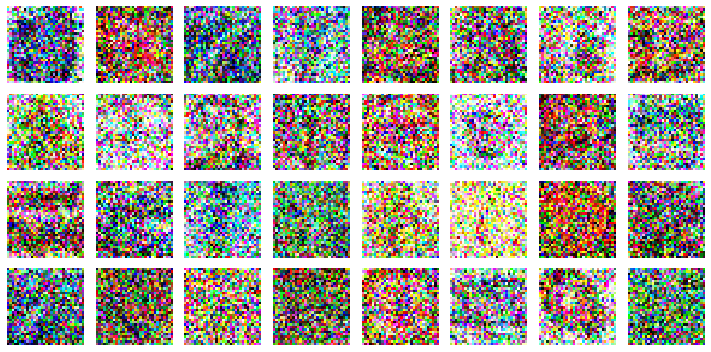

In [33]:
ans=recovered.reshape(batch_size,3,32,32) #.clamp(0,1)
print(ans.shape)
ans=ans.clone().detach()
#ans=(ans*std_inv+mean_inv).clamp(0,1)
plot_images(ans,rows=4,cols=8)
#torch.save(ans, "APRIL_64images_1500It.pt")
# plt.imshow(ans.permute(1,2,0).cpu())
# plt.axis("off")

In [34]:
torch.save(ans, "Adapter_Geiping_32images.pt")

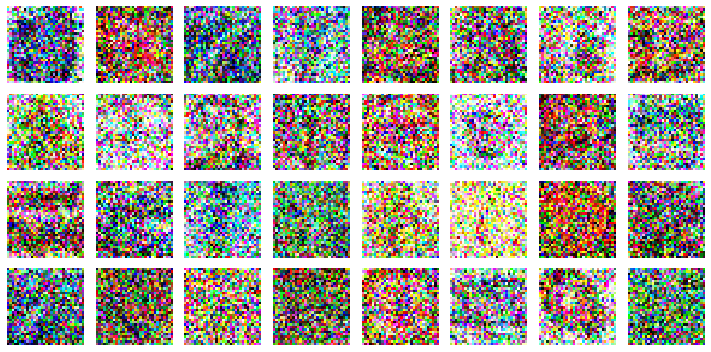

In [35]:
a=torch.load("Adapter_Geiping_32images.pt")
plot_images(a,rows=4,cols=8)

In [ ]:
plot_images(image_list,rows=4,cols=8)

In [ ]:
plot_images(image_list[32:64],rows=4,cols=8)

In [ ]:
plt.imshow((image_list[53]*std_inv+mean_inv).clamp(0,1).permute(1,2,0))
plt.axis("off")

In [ ]:
#torch.save(final,"CIFAR100_32images.pt")
a=torch.load("CIFAR100_32images_final_sorted.pt")
plot_images(a, rows=4, cols=8)

In [ ]:
plot_images(image_list,rows=8,cols=8)

In [ ]:
batch_size=32
ans=torch.load("CIFAR100_32images_final_sorted.pt")
import lpips
import torch
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from PIL import Image
transform = transforms.ToTensor()
lpips_model = lpips.LPIPS(net='alex')
dev=torch.device("cpu")
lpips_model.to(dev)
# Forward pass to compute the LPIPS distance
lpips_distance=[]
mse=[]
ssim_list=[]
psnr=[]
factor=1
with torch.no_grad():
    for i in range(batch_size):
        lpips_distance.append(lpips_model(ans[i], image_list[i]).item())
        mse.append((ans[i].detach()-image_list[i]).pow(2).mean())
        img1_np = ans[i][:,16:32,0:16]*std_inv+mean_inv
        img1_np = img1_np.cpu().detach().numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
        img2_np = image_list[i][:,16:32,0:16]*std_inv+mean_inv
        img2_np = img2_np.cpu().detach().numpy().transpose(1, 2, 0)
        mse_term=(ans[i].detach()-image_list[i]).pow(2).mean()
        psnr.append(10 * torch.log10(factor**2 / mse_term))
    # Compute SSIM, setting multichannel=True and win_size to 3
        ssim_value, _ = ssim(img1_np, img2_np, full=True, multichannel=True, win_size=3)
        ssim_list.append(ssim_value)
#print(f'LPIPS Distance: {lpips_distance}')
lpips_avg=np.mean(np.array(lpips_distance))
lpips_std=np.std(np.array(lpips_distance))
mse_avg=np.mean(np.array(mse))
mse_std=np.std(np.array(mse))
psnr_avg=np.mean(np.array(psnr))
ssim_avg=np.mean(np.array(ssim_list))
ssim_std=np.std(np.array(ssim_list))
print("lpips_avg:",lpips_avg)
print("lpips_std:",lpips_std)
print("mse_avg:",mse_avg)
print("mse_std:",mse_std)
print("ssim_avg:",ssim_avg)
print("ssim_std:",ssim_std)
print(psnr_avg)

In [ ]:
ans=torch.load("CIFAR100_32images_final_sorted.pt")
import lpips
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from PIL import Image
transform = transforms.ToTensor()
lpips_model = lpips.LPIPS(net='alex')
dev=torch.device("cpu")
lpips_model.to(dev)
# Forward pass to compute the LPIPS distance
lpips_distance=[]
mse=[]
ssim_list=[]
psnr=[]
factor=1
factor=torch.tensor(factor)
with torch.no_grad():
    for i in range(32):
        row_col_pairs = [
            (0, 16, 0, 16),
            (0, 16, 16, 32),
            (16, 32, 0, 16),
            (16, 32, 16, 32)
        ]
        
        for row1, row2, col1, col2 in row_col_pairs:
            patch = ans[i][:, row1:row2, col1:col2]
            if not patch.equal(torch.zeros(3, 16, 16)):
                # Resize patch to 64x64 for LPIPS compatibility
                resized_patch = F.interpolate(patch.unsqueeze(0), size=(32,32), mode='bilinear', align_corners=False)
                resized_target = F.interpolate(image_list[i][:, row1:row2, col1:col2].unsqueeze(0), size=(32,32), mode='bilinear', align_corners=False)
                
                # Calculate LPIPS distance
                lpips_dist = lpips_model(resized_patch, resized_target).item()
                lpips_distance.append(lpips_dist)
#         row1,row2,col1,col2=0,16,0,16
#         if not ans[i][:,row1:row2,col1:col2].equal(torch.zeros(3,16,16)):
#             lpips_distance.append(lpips_model(ans[i][:,row1:row2,col1:col2], image_list[i][:,row1:row2,col1:col2]).item())
#         row1,row2,col1,col2=0,16,16,32
#         if not ans[i][:,row1:row2,col1:col2].equal(torch.zeros(3,16,16)):
#             lpips_distance.append(lpips_model(ans[i][:,row1:row2,col1:col2], image_list[i][:,row1:row2,col1:col2]).item())
#         row1,row2,col1,col2=16,32,0,16
#         if not ans[i][:,row1:row2,col1:col2].equal(torch.zeros(3,16,16)):
#             lpips_distance.append(lpips_model(ans[i][:,row1:row2,col1:col2], image_list[i][:,row1:row2,col1:col2]).item())
#         row1,row2,col1,col2=16,32,16,32
#         if not ans[i][:,row1:row2,col1:col2].equal(torch.zeros(3,16,16)):
#             lpips_distance.append(lpips_model(ans[i][:,row1:row2,col1:col2], image_list[i][:,row1:row2,col1:col2]).item())
        
        
        for row1, row2, col1, col2 in row_col_pairs:
            if not ans[i][:,row1:row2,col1:col2].equal(torch.zeros(3,16,16)):
                img1_np = ans[i][:,row1:row2,col1:col2]*std_inv+mean_inv
                img1_np = img1_np.cpu().detach().numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
                img2_np = image_list[i][:,row1:row2,col1:col2]*std_inv+mean_inv
                img2_np = img2_np.cpu().detach().numpy().transpose(1, 2, 0)
    
    # Compute SSIM, setting multichannel=True and win_size to 3
                ssim_value, _ = ssim(img1_np, img2_np, full=True, multichannel=True, win_size=3)
                ssim_list.append(ssim_value)
                mse.append((ans[i][:,row1:row2,col1:col2].detach()-image_list[i][:,row1:row2,col1:col2]).pow(2).mean())
                mse_term=(ans[i][:,row1:row2,col1:col2].detach()-image_list[i][:,row1:row2,col1:col2]).pow(2).mean()
                psnr.append(10 * torch.log10(factor**2 / mse_term))
                
#print(f'LPIPS Distance: {lpips_distance}')
lpips_avg=np.mean(np.array(lpips_distance))
lpips_std=np.std(np.array(lpips_distance))
mse_avg=np.mean(np.array(mse))
mse_std=np.std(np.array(mse))
psnr_avg=np.mean(np.array(psnr))
ssim_avg=np.mean(np.array(ssim_list))
ssim_std=np.std(np.array(ssim_list))
print("mse_avg:",mse_avg)
print("mse_std:",mse_std)
print("lpips_avg:",lpips_avg)
print("lpips_std:",lpips_std)
#print(mse_avg)
print("ssim_avg:",ssim_avg)
print("ssim_std:",ssim_std)
print(psnr_avg)

In [ ]:
print(np.min(lpips_distance))
print(np.max(lpips_distance))

In [ ]:
#sorted_batch=torch.load("CIFAR100_64images_ours_sorted.pt")
#plot_images(sorted_batch,rows=8,cols=8)

In [ ]:
plot_images(image_list,rows=4,cols=8)

In [ ]:
def plot_images(images, rows, cols):
    images = images.clone().detach()
    images=(images*std_inv+mean_inv).clamp(0,1)
    
    fig, axes = plt.subplots(rows, cols, figsize=(6, 5))
    for i, ax in enumerate(axes.flat):
        #ax.imshow(images[i].transpose(1, 2, 0))
        #images[i]=images[i].reshape(3,32,32)
        ax.imshow(images[i].permute(1, 2, 0).cpu());
        ax.axis('off')
    plt.tight_layout()
    plt.show()